In [1]:
import argparse, os, csv, numpy as np
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D
from keras.models import Model, Sequential
from keras import optimizers
from random import shuffle
from PIL import Image
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_error
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator


/home/hackathon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data = '../data/train_image'
val_data = '../data/val_image'
train_label = '../data/coordinates/translated_coords.csv'
val_label = '../data/coordinates/translated_coords_val.csv'

In [3]:
def model():
    input_x = Input(shape=(224, 224, 3))
    first_layer = Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu')(input_x)
    first_layer = BatchNormalization()(first_layer)
    first_layer = Dropout(0.5)(first_layer)
    
    second_layer = Conv2D(64, (5,5), activation='relu')(first_layer)
    second_layer = GlobalAveragePooling2D()(second_layer)
    second_layer = Dropout(0.5)(second_layer)
    
    first_fc = Dense(2)(second_layer)
    second_fc = Dense(2)(second_layer)
    third_fc = Dense(2)(second_layer)
    fourth_fc = Dense(2)(second_layer)
    
    model = Model(inputs=input_x, outputs=[first_fc, second_fc, third_fc, fourth_fc])
    sgd = optimizers.SGD(lr=0.001, clipvalue=0.5)
    model.compile(loss=mean_squared_error, optimizer=sgd, metrics=['accuracy'])
    
    print(model.summary)
    
    return model

In [4]:
model = model()
model.summary()

<bound method Container.summary of <keras.engine.training.Model object at 0x7fa1ec7406d8>>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 220, 220, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 220, 220, 32) 0           batch_normalization_1[0][0]      
__________________

In [5]:
def get_filenames(label):
    with open(label, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        filenames = [f[0] for f in csv_reader]
    shuffle(filenames)
    return filenames

In [6]:
def data_read(data, label, filenames):
    x, y1, y2, y3, y4, file_index = [], [], [], [], [], []
    feature1, feature2, feature3, feature4 = [], [], [], []
    with open(label, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            file_index.append(row[0])
            feature1.append(row[1:3])
            feature2.append(row[3:5])
            feature3.append(row[5:7])
            feature4.append(row[7:])

    for file in filenames:
        input_path = os.path.join(data, file)
        im = np.asarray(Image.open(input_path))
        x.append(im)

        idx = file_index.index(file)
        y1.append(feature1[idx])
        y2.append(feature2[idx])
        y3.append(feature3[idx])
        y4.append(feature4[idx])

    return np.array(x), np.array(y1), np.array(y2), np.array(y3), np.array(y4)

In [16]:
def generator(batch_size, data, label):
    filenames = get_filenames(label)
    counter = 0
    while 1:
        if counter >= len(filenames):
            counter = 0
        X, y1, y2, y3, y4 = [], [], [], [], []
        shuffle(filenames)
        files_to_select = filenames[counter*batch_size:(counter+1)*batch_size]
        X, y1, y2, y3, y4 = data_read(data, label, files_to_select)
        
        y = [y1, y2, y3, y4]
        yield X, y

In [8]:
tg = generator(10, train_data, train_label)
for e in range(3):
    ex, ey = next(tg)
    print(len(ex), len(ey[0]))

41 41
41 41
41 41


In [9]:
def visualization(history):
    # summarize history for accuracy
    plt.plot(history.history['dense_4_acc'])
    plt.plot(history.history['val_dense_4_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dense_4_acc', 'val_dense_4_acc'], loc='upper left')
    fig = plt.figure()
    fig.savefig('../visual/accuracy.png')
    plt.show()
    
    # summarize history for accuracy
    plt.plot(history.history['dense_1_acc'])
    plt.plot(history.history['val_dense_1_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dense_1_acc', 'val_dense_1_acc'], loc='upper left')
    fig = plt.figure()
    fig.savefig('../visual/accuracy.png')
    plt.show()
    
    # summarize history for accuracy
    plt.plot(history.history['dense_2_acc'])
    plt.plot(history.history['val_dense_2_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dense_2_acc', 'val_dense_2_acc'], loc='upper left')
    fig = plt.figure()
    fig.savefig('../visual/accuracy.png')
    plt.show()
    
    # summarize history for accuracy
    plt.plot(history.history['dense_3_acc'])
    plt.plot(history.history['val_dense_3_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['dense_3_acc', 'val_dense_3_acc'], loc='upper left')
    fig = plt.figure()
    fig.savefig('../visual/accuracy.png')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['dense_4_loss'])
    plt.plot(history.history['val_dense_4_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['dense_4_loss', 'val_dense_4_loss'], loc='upper left')
    fig_loss = plt.figure()
    fig_loss.savefig('../visual/loss.png')
    plt.show()

In [18]:
def train():
    batch_size = 10
    #tensorboard = Tensorboard(log_dir = '../logs')
    
    filepath="../model_ckpts/weights-improvement-{epoch:02d}-{val_dense_1_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_dense_3_acc', verbose=1, save_best_only=True, mode='max')

    train_files = get_filenames(train_label)
    val_files = get_filenames(val_label)
    
    train_x, y1, y2, y3, y4 = data_read(train_data, train_label, train_files)
    val_x, val_y1, val_y2, val_y3, val_y4 = data_read(val_data, val_label, val_files)
    
    train_gen = generator(batch_size, train_data, train_label)
    val_gen = generator(batch_size, val_data, val_label)
    
    history = model.fit_generator(train_gen, steps_per_epoch=int(410/batch_size), epochs=100, verbose=1,
                                  callbacks=[checkpoint], validation_data=val_gen,
                                    validation_steps=int(178/batch_size))
    
    visualization(history=history)

Epoch 1/100
41/41 [==============================] - 3s 65ms/step - loss: 1307.2718 - dense_1_loss: 167.3029 - dense_2_loss: 273.4504 - dense_3_loss: 461.8621 - dense_4_loss: 404.6564 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.8415 - dense_4_acc: 1.0000 - val_loss: 836.7557 - val_dense_1_loss: 130.6453 - val_dense_2_loss: 127.6363 - val_dense_3_loss: 301.7953 - val_dense_4_loss: 276.6787 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9118 - val_dense_4_acc: 1.0000

Epoch 00001: val_dense_3_acc improved from -inf to 0.91176, saving model to ../model_ckpts/weights-improvement-01-1.00.hdf5
Epoch 2/100
41/41 [==============================] - 3s 64ms/step - loss: 1331.0515 - dense_1_loss: 174.4155 - dense_2_loss: 280.1921 - dense_3_loss: 488.2711 - dense_4_loss: 388.1729 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.8951 - dense_4_acc: 1.0000 - val_loss: 2335.5210 - val_dense_1_loss: 449.2692 - val_dense_2_loss: 509.7391 - val_dens

41/41 [==============================] - 3s 64ms/step - loss: 1328.8685 - dense_1_loss: 176.3189 - dense_2_loss: 259.9541 - dense_3_loss: 492.1397 - dense_4_loss: 400.4558 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9073 - dense_4_acc: 1.0000 - val_loss: 748.6319 - val_dense_1_loss: 179.8814 - val_dense_2_loss: 122.1665 - val_dense_3_loss: 175.9389 - val_dense_4_loss: 270.6451 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9294 - val_dense_4_acc: 1.0000

Epoch 00015: val_dense_3_acc did not improve
Epoch 16/100
41/41 [==============================] - 3s 64ms/step - loss: 1330.8532 - dense_1_loss: 167.2215 - dense_2_loss: 272.8224 - dense_3_loss: 487.6942 - dense_4_loss: 403.1151 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.8951 - dense_4_acc: 1.0000 - val_loss: 861.5912 - val_dense_1_loss: 171.9303 - val_dense_2_loss: 105.0126 - val_dense_3_loss: 243.1751 - val_dense_4_loss: 341.4732 - val_dense_1_acc: 1.0000 - val_dense_2_acc


Epoch 00029: val_dense_3_acc did not improve
Epoch 30/100
41/41 [==============================] - 3s 64ms/step - loss: 1254.8128 - dense_1_loss: 158.2322 - dense_2_loss: 248.9114 - dense_3_loss: 453.5617 - dense_4_loss: 394.1074 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9317 - dense_4_acc: 1.0000 - val_loss: 860.8351 - val_dense_1_loss: 151.0652 - val_dense_2_loss: 142.4759 - val_dense_3_loss: 262.7314 - val_dense_4_loss: 304.5627 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9059 - val_dense_4_acc: 1.0000

Epoch 00030: val_dense_3_acc did not improve
Epoch 31/100
41/41 [==============================] - 3s 64ms/step - loss: 1235.9658 - dense_1_loss: 156.8032 - dense_2_loss: 246.2630 - dense_3_loss: 451.1357 - dense_4_loss: 381.7640 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9024 - dense_4_acc: 1.0000 - val_loss: 6209.9346 - val_dense_1_loss: 659.6526 - val_dense_2_loss: 1099.4887 - val_dense_3_loss: 2658.7684 - val_dens

41/41 [==============================] - 3s 64ms/step - loss: 1118.3788 - dense_1_loss: 138.6938 - dense_2_loss: 224.4361 - dense_3_loss: 420.3482 - dense_4_loss: 334.9006 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9171 - dense_4_acc: 1.0000 - val_loss: 896.7447 - val_dense_1_loss: 152.0622 - val_dense_2_loss: 176.3410 - val_dense_3_loss: 293.2757 - val_dense_4_loss: 275.0659 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9412 - val_dense_4_acc: 1.0000

Epoch 00044: val_dense_3_acc did not improve
Epoch 45/100
41/41 [==============================] - 3s 64ms/step - loss: 1224.0922 - dense_1_loss: 157.6800 - dense_2_loss: 245.6299 - dense_3_loss: 454.1666 - dense_4_loss: 366.6157 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9122 - dense_4_acc: 1.0000 - val_loss: 970.8628 - val_dense_1_loss: 153.1790 - val_dense_2_loss: 146.1971 - val_dense_3_loss: 310.4909 - val_dense_4_loss: 360.9958 - val_dense_1_acc: 1.0000 - val_dense_2_acc


Epoch 00058: val_dense_3_acc did not improve
Epoch 59/100
41/41 [==============================] - 3s 64ms/step - loss: 1357.3464 - dense_1_loss: 172.8325 - dense_2_loss: 264.0726 - dense_3_loss: 503.5849 - dense_4_loss: 416.8564 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9366 - dense_4_acc: 1.0000 - val_loss: 6306.6047 - val_dense_1_loss: 552.2359 - val_dense_2_loss: 1057.6384 - val_dense_3_loss: 2667.6211 - val_dense_4_loss: 2029.1094 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9235 - val_dense_4_acc: 1.0000

Epoch 00059: val_dense_3_acc did not improve
Epoch 60/100
41/41 [==============================] - 3s 64ms/step - loss: 1142.1140 - dense_1_loss: 143.6217 - dense_2_loss: 235.4359 - dense_3_loss: 422.5006 - dense_4_loss: 340.5559 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9073 - dense_4_acc: 1.0000 - val_loss: 2755.5557 - val_dense_1_loss: 358.1358 - val_dense_2_loss: 504.5076 - val_dense_3_loss: 1073.6454 - val_d


Epoch 00073: val_dense_3_acc did not improve
Epoch 74/100
41/41 [==============================] - 3s 63ms/step - loss: 1166.0310 - dense_1_loss: 153.8726 - dense_2_loss: 237.9894 - dense_3_loss: 424.9469 - dense_4_loss: 349.2222 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9122 - dense_4_acc: 1.0000 - val_loss: 2022.1357 - val_dense_1_loss: 358.4999 - val_dense_2_loss: 410.9671 - val_dense_3_loss: 680.7456 - val_dense_4_loss: 571.9230 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9294 - val_dense_4_acc: 1.0000

Epoch 00074: val_dense_3_acc did not improve
Epoch 75/100
41/41 [==============================] - 3s 64ms/step - loss: 1168.6975 - dense_1_loss: 148.2238 - dense_2_loss: 229.9428 - dense_3_loss: 430.2907 - dense_4_loss: 360.2402 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9122 - dense_4_acc: 1.0000 - val_loss: 5211.4786 - val_dense_1_loss: 673.2747 - val_dense_2_loss: 1010.8770 - val_dense_3_loss: 2017.8105 - val_den


Epoch 00088: val_dense_3_acc did not improve
Epoch 89/100
41/41 [==============================] - 3s 64ms/step - loss: 1107.2286 - dense_1_loss: 139.0319 - dense_2_loss: 225.6428 - dense_3_loss: 409.9123 - dense_4_loss: 332.6416 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.9146 - dense_4_acc: 1.0000 - val_loss: 3341.9784 - val_dense_1_loss: 529.7998 - val_dense_2_loss: 653.8922 - val_dense_3_loss: 1168.9001 - val_dense_4_loss: 989.3863 - val_dense_1_acc: 1.0000 - val_dense_2_acc: 1.0000 - val_dense_3_acc: 0.9000 - val_dense_4_acc: 1.0000

Epoch 00089: val_dense_3_acc did not improve
Epoch 90/100
41/41 [==============================] - 3s 64ms/step - loss: 1242.8716 - dense_1_loss: 158.2189 - dense_2_loss: 251.4573 - dense_3_loss: 460.2275 - dense_4_loss: 372.9678 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 0.8976 - dense_4_acc: 1.0000 - val_loss: 1211.4775 - val_dense_1_loss: 206.0771 - val_dense_2_loss: 193.4797 - val_dense_3_loss: 386.0211 - val_dens

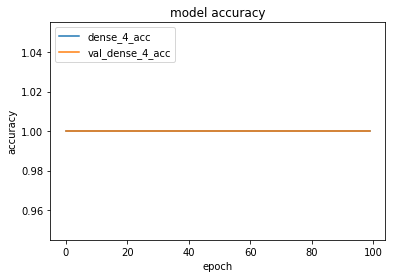

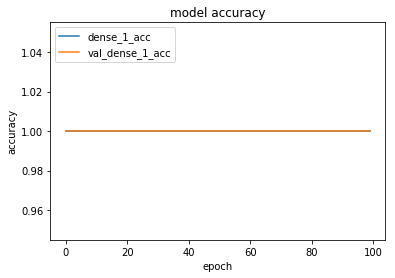

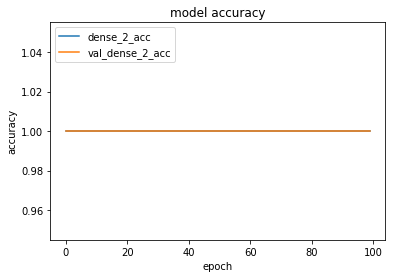

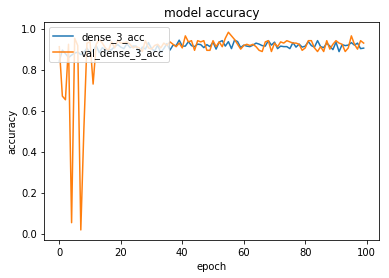

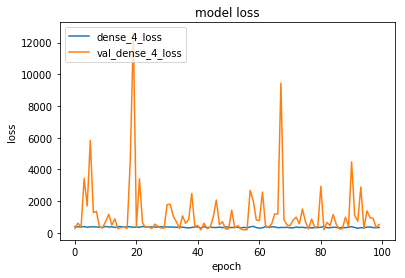

In [19]:
train()